# Transfer Learning - 1

Transfer learning is leaveraging a working model's existing architecture and learned patterns for our own problems.


There are two main benifits:
1. We can leverage an existing neural network architecture proven to work on problems similar to our own.
2. We can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own.

In [1]:
!nvidia-smi

Mon Mar 27 10:40:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##DATASET: 10% of the food vision model
- The below used link has 10% of the food vision data. 
- This is used for the train and testing of the Transfer Learning models.

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import datetime

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-03-27 10:40:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.1MB/s    in 7.5s    

2023-03-27 10:40:31 (21.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in \'{dirpath}\'')

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi

##Data Preprocessing: Using `ImageDataGenerator`
- It was observed in the CNN experiments that the preprocessed data can be very helpful to build a robust model.
- Hence, in this transfer learning experimental curve, the data is subjected to the following changes; rescaling, rotation, shearing (slants' the shape), zoomed in, dimensional variations, and horizontal fliping.
- The Final image size and the batch size has already been set in the begginning of the preprocessing.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

image_datagen = idg(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True)

print('Training Images')
train_data_10_percent = image_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True
)

print('Testing Images')

test_data_10_percent = image_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True
)

Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


In [5]:
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [6]:
import matplotlib.image as mpimg
import random

def view_random(target_dir, target_class):
  target_folder = target_dir+target_class
  rand_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder+'/'+rand_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image Shape: {img.shape}')

def plot_history(history_name):
  model_history = pd.DataFrame(history_name.history)
  model_history.plot(figsize=(11,8), title = 'Model_Performance', xlabel = 'epochs', ylabel = 'performance')

Image Shape: (512, 512, 3)


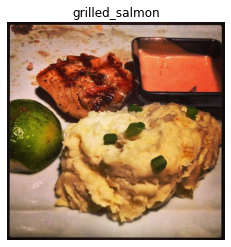

In [7]:
view_random(train_dir+'/', random.choice(class_names))

##Setting up callbacks 

**These are things to run while the model is training.** 

Call backs are extra functionality that we can add to the models to be performed during or after training. Some popular callbacks are:



*  **TensorBoard** - Logs the performance of multiple models and then view and compare these models in a visula way on Tensorboard. It's helpful to compare the results of different models on the data.
*  **Model Checkpointing** - Saving the model as it trains so you can stop training if needed and can used to continue where we left off. Helpful if training takes a long time and can't be done at once.
*  **Early Stopping** - This is helpful in model training for arbitrary amount of time and have it stoped when it ceases to show any imporvement. Helpful in the case of large dataset and don't know how long training will it take.



In [8]:
#TensorBoard for this learning path

import datetime

def create_tensorboard_callback(dirName, experimentName):
  logDir = dirName + '/' + experimentName + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logDir)
  print(f'TensorBoard is saved to : \"{logDir}\"')
  return tensorboard_callback

## Tensorflow Hub

**Tensorflow hub is a one place stop for all kinds of pre-trained models**

All these models can be accessed from `hhtps://tfhub.dev/`
For the purpose of this learning cure, I am using 2 models.

1. ResNet 50 V2 - `https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5`
2. EfficientNet V2 b0 - `https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2` 

In [9]:
resNet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientNet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"

In [10]:
import tensorflow_hub as hub
def createModel(model_url, num_classes = len(class_names)):
  feature_extractor_layer = hub.KerasLayer(model_url, trainable= False, name= 'feature_extraction_layer', input_shape = IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])
  return model


In [11]:
resnet_model = createModel(resNet_url)
resnet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps= len(test_data_10_percent),
                                  callbacks = [create_tensorboard_callback(dirName="tensorflow_hub",
                                                                         experimentName="resnet50V2")])

TensorBoard is saved to : "tensorflow_hub/resnet50V2/20230327-104049"
Epoch 1/5
24/24 [==============================] - 67s 2s/step - loss: 2.0650 - accuracy: 0.3053 - val_loss: 1.4153 - val_accuracy: 0.5356
Epoch 2/5
24/24 [==============================] - 49s 2s/step - loss: 1.1384 - accuracy: 0.6360 - val_loss: 1.0398 - val_accuracy: 0.6692
Epoch 3/5
24/24 [==============================] - 49s 2s/step - loss: 0.9344 - accuracy: 0.7040 - val_loss: 0.9134 - val_accuracy: 0.6944
Epoch 4/5
24/24 [==============================] - 59s 3s/step - loss: 0.7456 - accuracy: 0.7587 - val_loss: 0.8471 - val_accuracy: 0.7208
Epoch 5/5
24/24 [==============================] - 63s 3s/step - loss: 0.6747 - accuracy: 0.7947 - val_loss: 0.7980 - val_accuracy: 0.7368


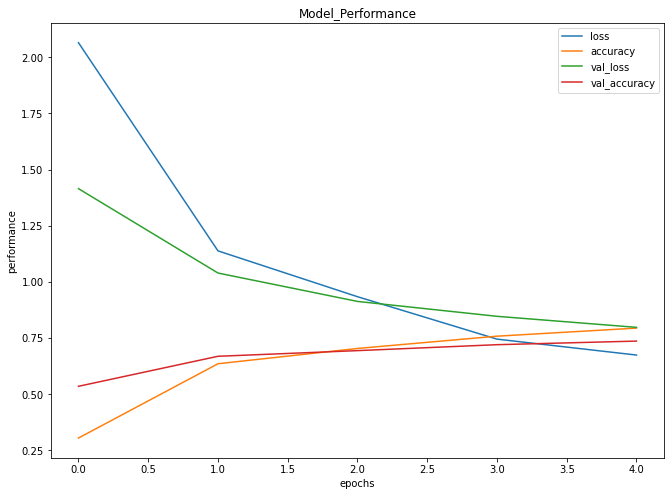

In [14]:
plot_history(resnet_history)

In [15]:


efficientnet_model = createModel(model_url=efficientNet_url, 
                                  num_classes=train_data_10_percent.num_classes)


efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dirName="tensorflow_hub",
                                                                                     experimentName="efficientnetB0")])

TensorBoard is saved to : "tensorflow_hub/efficientnetB0/20230327-104547"
Epoch 1/5
24/24 [==============================] - 107s 4s/step - loss: 2.2905 - accuracy: 0.2507 - val_loss: 1.5474 - val_accuracy: 0.4700
Epoch 2/5
24/24 [==============================] - 55s 2s/step - loss: 1.3068 - accuracy: 0.5720 - val_loss: 1.1587 - val_accuracy: 0.6220
Epoch 3/5
24/24 [==============================] - 56s 2s/step - loss: 1.0132 - accuracy: 0.6600 - val_loss: 1.0614 - val_accuracy: 0.6520
Epoch 4/5
24/24 [==============================] - 54s 2s/step - loss: 0.8631 - accuracy: 0.7293 - val_loss: 0.9710 - val_accuracy: 0.6792
Epoch 5/5
24/24 [==============================] - 95s 4s/step - loss: 0.7713 - accuracy: 0.7320 - val_loss: 0.9226 - val_accuracy: 0.6968


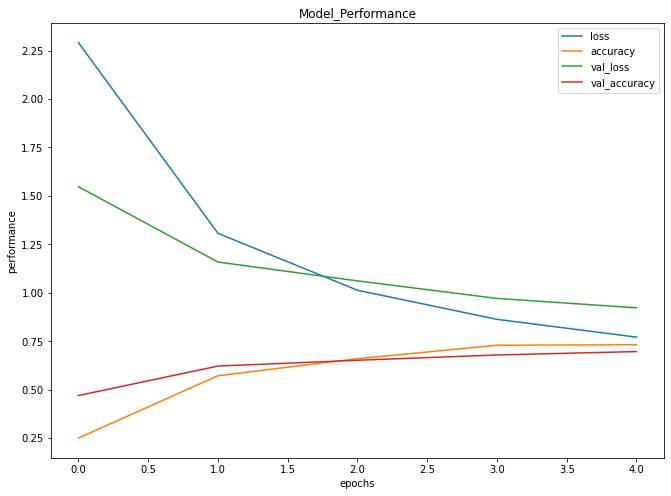

In [16]:
plot_history(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1000)             7200312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 7,210,322
Trainable params: 10,010
Non-trainable params: 7,200,312
_________________________________________________________________


In [18]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-03-27 10:51:57.829585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-27 10:51:57.829734: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-27 10:51:57.829767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoar

In [19]:
# Check out experiments
!tensorboard dev list

2023-03-27 10:53:27.014873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-27 10:53:27.014972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-27 10:53:27.014991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/VBnO8tBYRf6eG06v22BU4w/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub fea

In [20]:
# Delete an experiment
!tensorboard dev delete --experiment_id sjvyOVhOQ2SjES0MO9aqCg

2023-03-27 10:53:30.995512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-27 10:53:30.995635: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-27 10:53:30.995656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
No such experiment sjvyOVhOQ2SjES0MO9aqCg. Either it never existed or it has already been deleted.

